# PERBANDINGAN METODE TRIPLE EXPONENTIAL SMOOTHING DAN AUTOREGRESSIVE INTEGRATED MOVING AVERAGE (ARIMA) PADA PERAMALAN HARGA CRYPTOCURRENCY (STUDI KASUS: LIMA KOIN KRIPTO TERATAS)

1. Set-Up
2. EDA
3. Data Preprocessing
4. Modelling
5. Hyperparameter Tuning
6. Evaluation


# SET-UP

## Import Library

In [58]:
# data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import itertools
import warnings
import time
warnings.filterwarnings("ignore")

#EDA
from tabulate import tabulate
# ouliers
from scipy import stats
# train test split
from pmdarima.model_selection import train_test_split

# metrics evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#import auto_arima

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Import Data

In [59]:
data_final = pd.read_csv("dataset/BTC-USD.csv")
data_final1 = pd.read_csv("dataset/BTC-USD.csv", parse_dates=['Date'], index_col='Date')
data_final2 = pd.read_csv("dataset/ETH-USD.csv", parse_dates=['Date'], index_col='Date')
data_final3 = pd.read_csv("dataset/BNB-USD.csv", parse_dates=['Date'], index_col='Date')
data_final4 = pd.read_csv("dataset/SOL-USD.csv",parse_dates=['Date'], index_col='Date')
data_final5 = pd.read_csv("dataset/XRP-USD.csv",parse_dates=['Date'], index_col='Date')

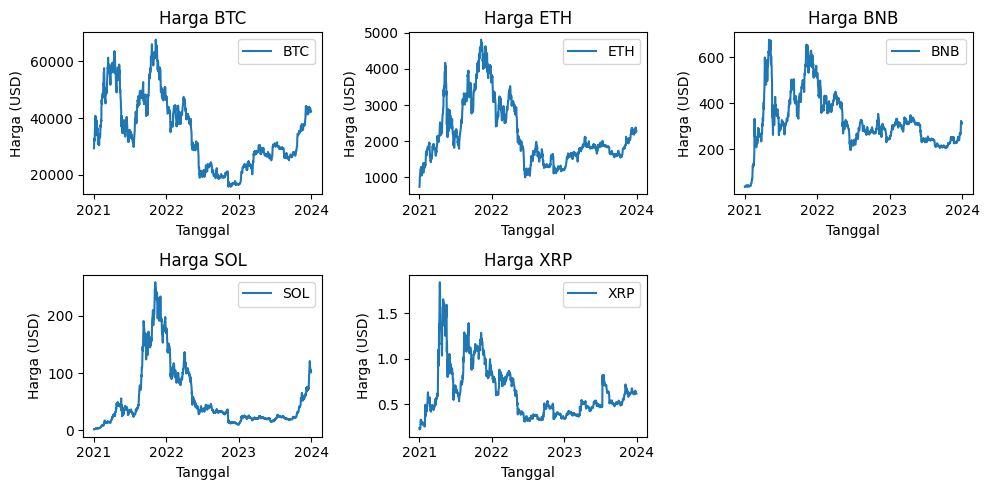

In [60]:
# Daftar koin dan data frames
coins = ['BTC', 'ETH', 'BNB', 'SOL', 'XRP']
data_frames = [data_final1, data_final2, data_final3, data_final4, data_final5]

# Mengatur ukuran plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each coin's data
for i, (coin, df) in enumerate(zip(coins, data_frames)):
    axes[i].plot(df.index, df['Close'], label=coin)
    axes[i].set_title(f'Harga {coin}')
    axes[i].legend()
    # Set major ticks to the start of each year
    axes[i].xaxis.set_major_locator(mdates.YearLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Menambahkan label pada sumbu x dan y
for ax in axes:
    ax.set_xlabel('Tanggal')
    ax.set_ylabel('Harga (USD)')

# Hide the empty subplot
if len(coins) < len(axes):
    for j in range(len(coins), len(axes)):
        fig.delaxes(axes[j])

# Menyesuaikan tata letak
plt.tight_layout()
plt.show()

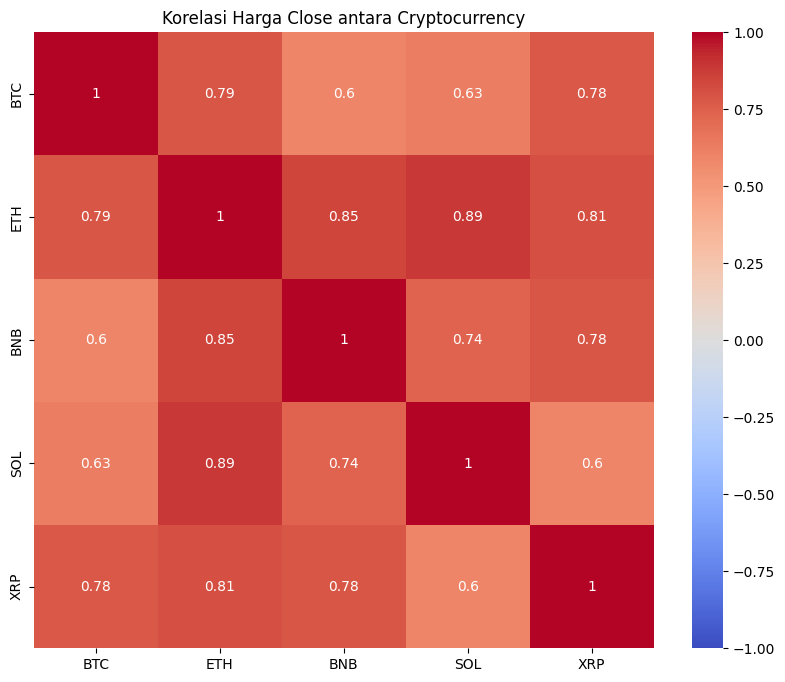

In [61]:
# Merge data on the Date index
combined_data = data_final1[['Close']].rename(columns={'Close': 'BTC'}).join(
                data_final2[['Close']].rename(columns={'Close': 'ETH'}), how='outer').join(
                data_final3[['Close']].rename(columns={'Close': 'BNB'}), how='outer').join(
                data_final4[['Close']].rename(columns={'Close': 'SOL'}), how='outer').join(
                data_final5[['Close']].rename(columns={'Close': 'XRP'}), how='outer')

# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korelasi Harga Close antara Cryptocurrency')
plt.show()

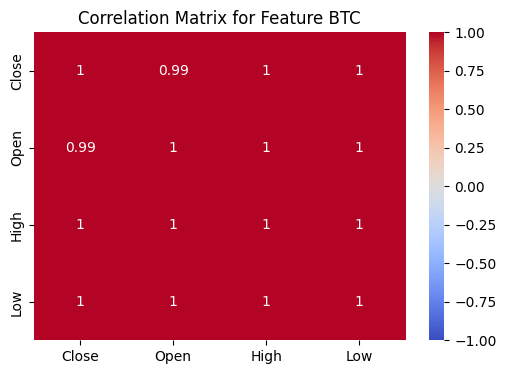

In [62]:
# Function to calculate correlation
corr_matrix = data_final1[['Close', 'Open', 'High', 'Low']].corr()

# Plot correlation matrices
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Feature BTC')
plt.show()

# EDA

In [63]:
#Import Data
data_final = pd.read_csv("dataset/BTC-USD.csv")
# Read Data
data_final

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
1,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
3,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914063,31971.914063,81163475344
4,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782
...,...,...,...,...,...,...,...
1090,2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032
1091,2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014
1092,2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055
1093,2023-12-30,42091.753906,42584.125000,41556.226563,42156.902344,42156.902344,16013925945


In [64]:
data_final.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1095.0,3.482320e+04,1.256097e+04,1.578230e+04,2.470548e+04,3.213887e+04,4.353272e+04,6.754973e+04
High,1095.0,3.561568e+04,1.292156e+04,1.625305e+04,2.521547e+04,3.332710e+04,4.418802e+04,6.878962e+04
Low,1095.0,3.395326e+04,1.213239e+04,1.559905e+04,2.427638e+04,3.103027e+04,4.256395e+04,6.638206e+04
Close,1095.0,3.483138e+04,1.255608e+04,1.578728e+04,2.469368e+04,3.218628e+04,4.355131e+04,6.756683e+04
Adj Close,1095.0,3.483138e+04,1.255608e+04,1.578728e+04,2.469368e+04,3.218628e+04,4.355131e+04,6.756683e+04
Volume,1095.0,3.180665e+10,2.053404e+10,5.331173e+09,1.863833e+10,2.783388e+10,3.851887e+10,3.509679e+11


In [65]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1095 non-null   object 
 1   Open       1095 non-null   float64
 2   High       1095 non-null   float64
 3   Low        1095 non-null   float64
 4   Close      1095 non-null   float64
 5   Adj Close  1095 non-null   float64
 6   Volume     1095 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 60.0+ KB


In [66]:
#drop feature that not used in this analysis ( 'Open', 'High', 'Low', 'Adj Close', 'Volume')
data_final = data_final.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
data_final

,Date,Close
0,2021-01-01,29374.152344
1,2021-01-02,32127.267578
2,2021-01-03,32782.023438
3,2021-01-04,31971.914063
4,2021-01-05,33992.429688
...,...,...
1090,2023-12-27,43442.855469
1091,2023-12-28,42627.855469
1092,2023-12-29,42099.402344
1093,2023-12-30,42156.902344


In [67]:
# Data Type Conversion
# Convert 'Date' to datetime if not already done
data_final['Date'] = pd.to_datetime(data_final['Date'])

#Feature Engineering
#Extract date parts
data_final['year'] = data_final['Date'].dt.year
data_final['month'] = data_final['Date'].dt.month
data_final['day'] = data_final['Date'].dt.day

data_final


,Date,Close,year,month,day
0,2021-01-01,29374.152344,2021,1,1
1,2021-01-02,32127.267578,2021,1,2
2,2021-01-03,32782.023438,2021,1,3
3,2021-01-04,31971.914063,2021,1,4
4,2021-01-05,33992.429688,2021,1,5
...,...,...,...,...,...
1090,2023-12-27,43442.855469,2023,12,27
1091,2023-12-28,42627.855469,2023,12,28
1092,2023-12-29,42099.402344,2023,12,29
1093,2023-12-30,42156.902344,2023,12,30


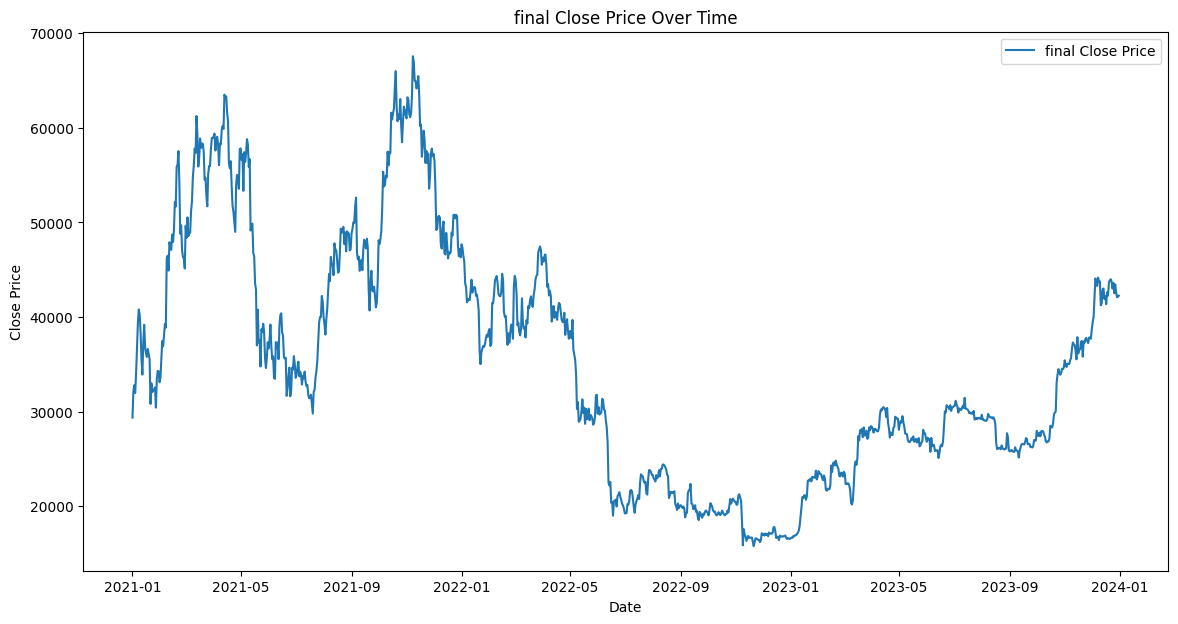

In [68]:
# visualisasi data close price / day
data_final.set_index('Date', inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(data_final['Close'], label='final Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('final Close Price Over Time')
plt.legend()
plt.show()


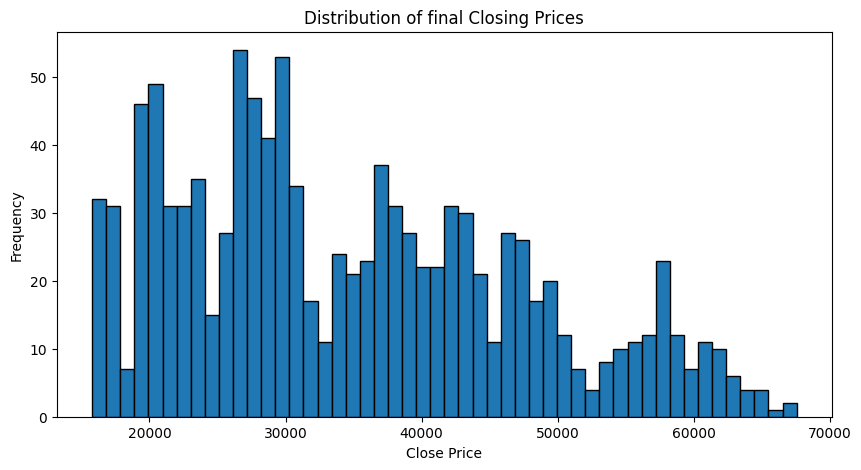

In [69]:
plt.figure(figsize=(10, 5))
plt.hist(data_final['Close'], bins=50, edgecolor='k')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Distribution of final Closing Prices')
plt.show()


<Figure size 1200x600 with 0 Axes>

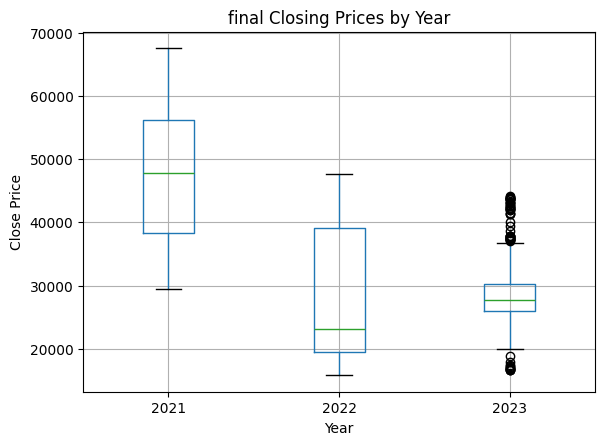

In [70]:
data_final['Year'] = data_final.index.year

plt.figure(figsize=(12, 6))
data_final.boxplot(column='Close', by='Year')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.title('final Closing Prices by Year')
plt.suptitle('')  # Suppress the automatic title
plt.show()

# DATA PREPROCESSING

Steps for Data Preprocessing:
1. Handling Missing Values 
2. Data Type Conversion ✅
3. Feature Engineering ✅
4. Normalization/Scaling (Tidak dilakukan karena model yang kita gunakan tidak membutuhkan scaling)
5. Handling Outliers

In [71]:
# Check for missing values
data_final.isnull().sum()


Close    0
year     0
month    0
day      0
Year     0
dtype: int64

In [72]:
# Menghitung Z-Score untuk kolom 'Close'
z_scores = np.abs(stats.zscore(data_final[['Close']]))

# Mengidentifikasi outlier (Z-Score > 3)
outlier_mask = (z_scores > 3).any(axis=1)

# Membuat kolom baru 'Close_interpolated' yang berisi data tanpa outlier
data_final['Close_interpolated'] = data_final['Close'].copy()

# Mengisi nilai outlier dengan interpolasi linear pada kolom 'Close_interpolated'
data_final.loc[outlier_mask, 'Close_interpolated'] = np.nan
data_final['Close_interpolated'].interpolate(method='linear', limit_direction='both', inplace=True)

# Menampilkan DataFrame yang telah diperbarui
print(data_final['Close_interpolated'])

Date
2021-01-01    29374.152344
2021-01-02    32127.267578
2021-01-03    32782.023438
2021-01-04    31971.914063
2021-01-05    33992.429688
                  ...     
2023-12-27    43442.855469
2023-12-28    42627.855469
2023-12-29    42099.402344
2023-12-30    42156.902344
2023-12-31    42265.187500
Name: Close_interpolated, Length: 1095, dtype: float64


In [73]:
# Melihat jumlah nilai yang hilang di setiap kolom
print(data_final.isnull().sum())

# Atau, melihat lokasi nilai yang hilang
print(data_final[data_final.isnull().any(axis=1)])

Close                 0
year                  0
month                 0
day                   0
Year                  0
Close_interpolated    0
dtype: int64
Empty DataFrame
Columns: [Close, year, month, day, Year, Close_interpolated]
Index: []


In [74]:
# Check Descriptive Statistic
print("\n\n")
print("Check Descriptive Statistic")
print(f"Data memiliki {data_final.shape[0]} baris dan {data_final.shape[1]} kolom")
data_final.describe().style.format("{:,.0f}")




Check Descriptive Statistic
Data memiliki 1095 baris dan 6 kolom


,Close,year,month,day,Year,Close_interpolated
count,"1,095","1,095","1,095","1,095","1,095","1,095"
mean,"34,831","2,022",7,16,"2,022","34,831"
std,"12,556",1,3,9,1,"12,556"
min,"15,787","2,021",1,1,"2,021","15,787"
25%,"24,694","2,021",4,8,"2,021","24,694"
50%,"32,186","2,022",7,16,"2,022","32,186"
75%,"43,551","2,023",10,23,"2,023","43,551"
max,"67,567","2,023",12,31,"2,023","67,567"


In [75]:
# Split train - test data
train_size = int(len(data_final) * 0.8)
train_final, test_final = data_final.iloc[:train_size], data_final.iloc[train_size:]

print(f"Jumlah data train: {len(train_final)} baris")
print(f"Jumlah data test: {len(test_final)} baris")

# Show the data
print("Train Data:")
print(train_final.head())
print("\nTest Data:")
print(test_final.head())


Jumlah data train: 876 baris
Jumlah data test: 219 baris
Train Data:
                   Close  year  month  day  Year  Close_interpolated
Date                                                                
2021-01-01  29374.152344  2021      1    1  2021        29374.152344
2021-01-02  32127.267578  2021      1    2  2021        32127.267578
2021-01-03  32782.023438  2021      1    3  2021        32782.023438
2021-01-04  31971.914063  2021      1    4  2021        31971.914063
2021-01-05  33992.429688  2021      1    5  2021        33992.429688

Test Data:
                   Close  year  month  day  Year  Close_interpolated
Date                                                                
2023-05-27  26868.353516  2023      5   27  2023        26868.353516
2023-05-28  28085.646484  2023      5   28  2023        28085.646484
2023-05-29  27745.884766  2023      5   29  2023        27745.884766
2023-05-30  27702.349609  2023      5   30  2023        27702.349609
2023-05-31  27219.6582

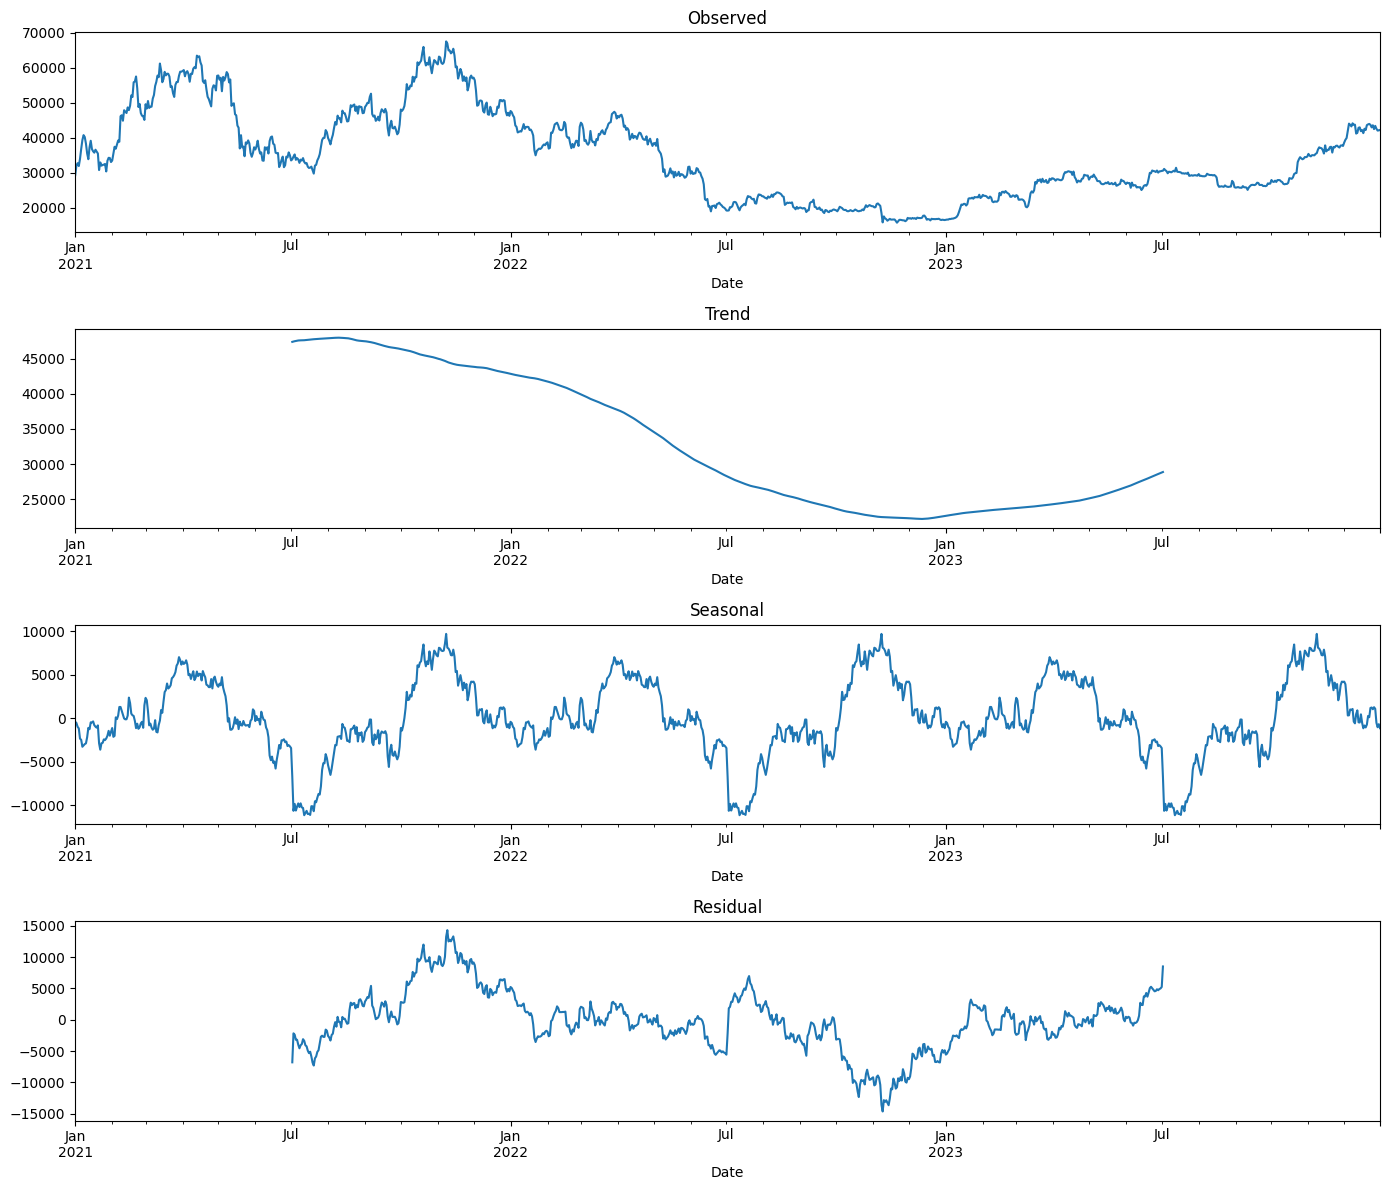

In [76]:
# Assuming data_final['Close'] is your time series data
result = seasonal_decompose(data_final['Close_interpolated'], model='additive', period=365)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

In [77]:
# Check for NaN values in the decomposed components
print("NaN in Trend component: ", result.trend.isna().sum())
print("NaN in Seasonal component: ", result.seasonal.isna().sum())
print("NaN in Residual component: ", result.resid.isna().sum())

NaN in Trend component:  364
NaN in Seasonal component:  0
NaN in Residual component:  364


# Modelling Manual

## Triple Exponential Smoothing

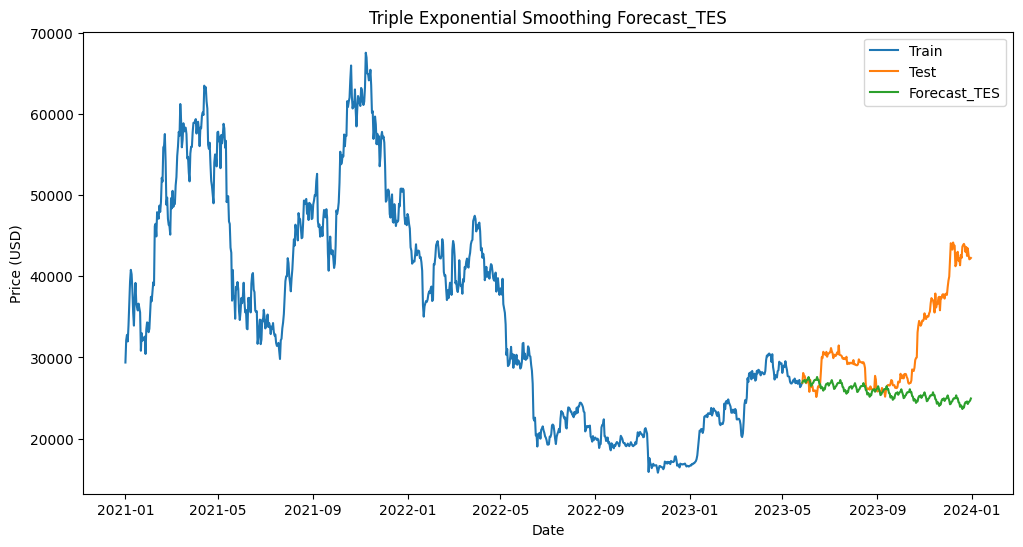

RMSE: 8540.20
MAPE: 16.29%


In [78]:
hw_train_df = train_final[['Close_interpolated']]
hw_test_df = test_final[['Close_interpolated']]

# Model Triple Exponential Smoothing (TES)
def fit_tes(train, test, seasonal_periods, level=None, slope=None, seasonal=None):
    # Build the model
    model = ExponentialSmoothing(train,  trend='add', seasonal='add', seasonal_periods=seasonal_periods)
    
    # Fit the model
    # model_fit = model.fit(optimized=True) // otomatis
    
    # manual
    model_fit = model.fit(smoothing_level=level, 
                          smoothing_slope=slope, 
                          smoothing_seasonal=seasonal, 
                          optimized=True if (level is None and slope is None and seasonal is None) else False) 
    
    # Forecast
    forecast_TES = model_fit.forecast(steps=len(test))
    
    return model_fit, forecast_TES

# Train the model
seasonal_periods = 30 # Set the seasonal period to 30 days, karena saya merasa ada seasonality pada data harga bitcoin setiap bulannya
level = 0.2   # Set level smoothing parameter
slope = 0.1   # Set slope smoothing parameter
seasonal = 0.3  # Set seasonal smoothing parameter
model_fit, forecast_TES = fit_tes(hw_train_df['Close_interpolated'], hw_test_df['Close_interpolated'], seasonal_periods, level, slope, seasonal)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(hw_train_df['Close_interpolated'], label='Train')
plt.plot(hw_test_df['Close_interpolated'], label='Test')
plt.plot(forecast_TES, label='Forecast_TES')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.title('Triple Exponential Smoothing Forecast_TES')
plt.show()

# Evaluate the model RMSE n MAPE
rmse_TES = np.sqrt(mean_squared_error(hw_test_df['Close_interpolated'], forecast_TES))
mape_TES = np.mean(np.abs((hw_test_df['Close_interpolated'] - forecast_TES) / hw_test_df['Close_interpolated'])) * 100

print(f'RMSE: {rmse_TES:.2f}')
print(f'MAPE: {mape_TES:.2f}%')


## ARIMA

In [79]:
arima_train_df = train_final[['Close_interpolated']]
arima_test_df = test_final[['Close_interpolated']]

#Check Stationary Data pada arima_train_df
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    if result[1] > 0.05:
        print("Series is non-stationary")
    else:
        print("Series is stationary")

# Check stationarity of Close prices
check_stationarity(arima_train_df['Close_interpolated'])

ADF Statistic: -1.504290
p-value: 0.531388
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Series is non-stationary


In [80]:
# Estimasi Parameter Model ARIMA
# Differencing to make data stationary
train_final_diff = arima_train_df['Close_interpolated'].diff().dropna()

check_stationarity(train_final_diff)

ADF Statistic: -30.554539
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Series is stationary


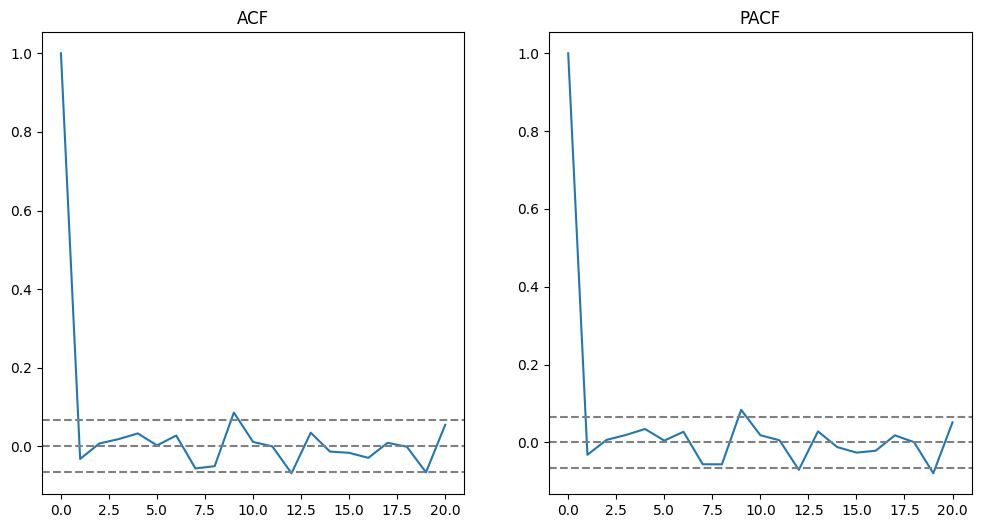

In [81]:
# Identifikasi Orde ARIMA (p, d, q)
# ACF and PACF plots
acf_plot = acf(train_final_diff, nlags=20)
pacf_plot = pacf(train_final_diff, nlags=20)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(acf_plot)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_final_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_final_diff)), linestyle='--', color='gray')
plt.title('ACF')
plt.subplot(122)
plt.plot(pacf_plot)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_final_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_final_diff)), linestyle='--', color='gray')
plt.title('PACF')
plt.show()

In [82]:
# Fit ARIMA model
model = ARIMA(arima_train_df, order=(1, 1, 1))  # order=(p,d,q) adjust based on ACF/PACF analysis
model_fit = model.fit()


# Print summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     Close_interpolated   No. Observations:                  876
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7591.299
Date:                Tue, 11 Jun 2024   AIC                          15188.598
Time:                        06:12:15   BIC                          15202.920
Sample:                    01-01-2021   HQIC                         15194.076
                         - 05-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1336     11.112     -0.012      0.990     -21.912      21.645
ma.L1          0.1310     11.115      0.012      0.991     -21.655      21.917
sigma2      2.003e+06   5.71e+04     35.083      0.0

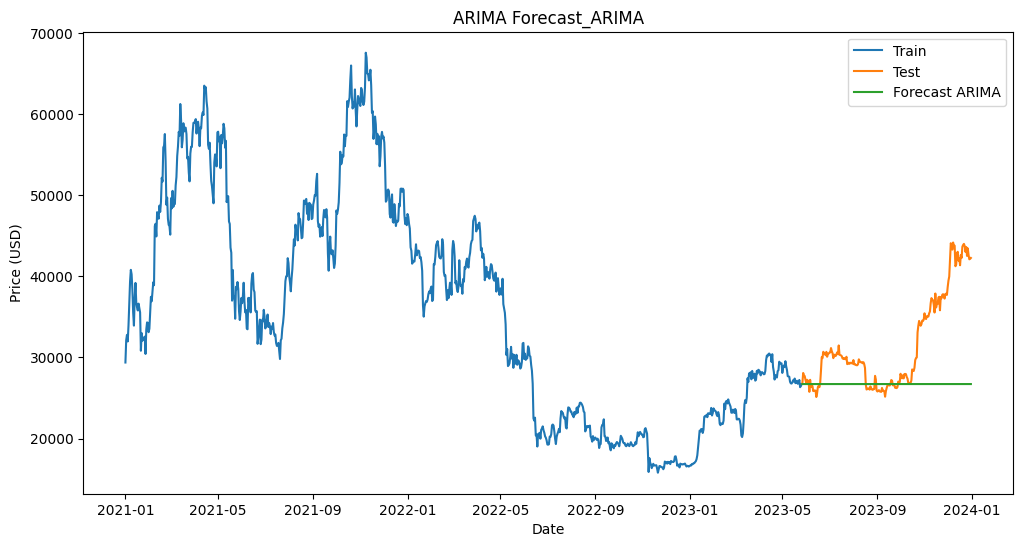

RMSE: 7390.74
MAPE: 13.74%


In [83]:
# Forecasting ARIMA
forecast_ARIMA = model_fit.forecast(steps=len(arima_test_df))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(arima_train_df['Close_interpolated'], label='Train')
plt.plot(arima_test_df['Close_interpolated'], label='Test')
plt.plot(arima_test_df.index, forecast_ARIMA, label='Forecast ARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.title('ARIMA Forecast_ARIMA')
plt.show()

# Evaluate the model RMSE n MAPE
rmse_ARIMA = np.sqrt(mean_squared_error(arima_test_df['Close_interpolated'], forecast_ARIMA))
mape_ARIMA = np.mean(np.abs((arima_test_df['Close_interpolated'] - forecast_ARIMA) / arima_test_df['Close_interpolated'])) * 100

print(f'RMSE: {rmse_ARIMA:.2f}')
print(f'MAPE: {mape_ARIMA:.2f}%')

# HYPERPARAMETER TUNING

## Triple Exponential Smoothing

In [84]:
# Hyperparameter Tuning TES
def tes_optimizer(train, test, seasonal_periods, abg):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    start_time = time.time()
    
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=seasonal_periods). \
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(len(test))
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print("Hyperparameter tuning completed in {:.2f} seconds".format(elapsed_time))
    print("Best Parameters -> alpha: {:.2f}, beta: {:.2f}, gamma: {:.2f}, MAE: {:.4f}".format(best_alpha, best_beta, best_gamma, best_mae))

    return best_alpha, best_beta, best_gamma, best_mae
# Generate combinations of alpha, beta, gamma
alphas = betas = gammas = np.arange(0.20, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
# Train the model and optimize hyperparameters
best_alpha, best_beta, best_gamma, _ = tes_optimizer(train_final['Close_interpolated'], test_final['Close_interpolated'], seasonal_periods, abg)

# Fit Model TES
def fit_tes(train, test, seasonal_periods, alpha, beta, gamma):
    # Build the model
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
    # Fit the model
    model_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
    # Forecast
    Tuning_TES = model_fit.forecast(steps=len(test))
    return model_fit, Tuning_TES

# Fit the model with best hyperparameters
model_fit, Tuning_TES = fit_tes(train_final['Close_interpolated'], test_final['Close_interpolated'], seasonal_periods, best_alpha, best_beta, best_gamma)

Hyperparameter tuning completed in 88.82 seconds
Best Parameters -> alpha: 0.50, beta: 0.80, gamma: 0.20, MAE: 3203.6516


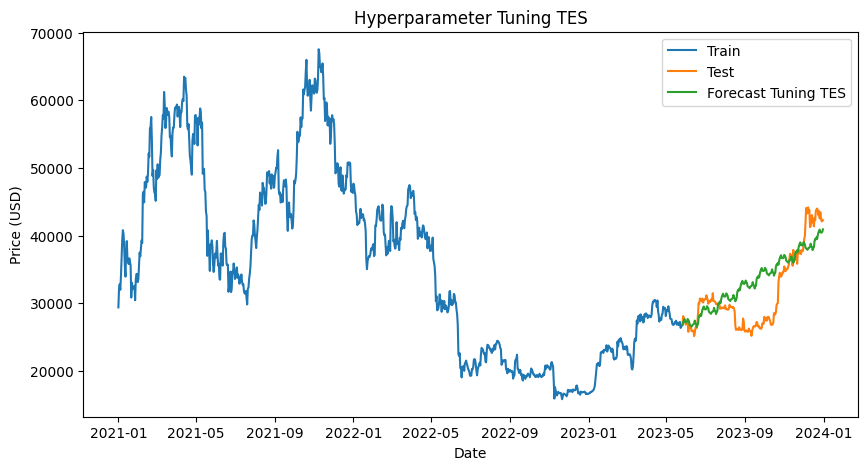

Best Alpha: 0.5000000000000001
Best Beta: 0.8000000000000003
Best Gamma: 0.2
RMSE Tuned TES: 4130.77
MAPE Tuned TES: 10.93%


In [98]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(train_final['Close_interpolated'], label='Train')
plt.plot(test_final['Close_interpolated'], label='Test')
plt.plot(Tuning_TES, label='Forecast Tuning TES')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.title('Hyperparameter Tuning TES')
plt.show()

# Evaluate the model RMSE n MAPE
rmse_tuned_TES = np.sqrt(mean_squared_error(test_final['Close_interpolated'], Tuning_TES))
mape_tuned_TES = np.mean(np.abs((test_final['Close_interpolated'] - Tuning_TES) / test_final['Close_interpolated'])) * 100
# print best aplha, beta, gammma
print(f'Best Alpha: {best_alpha}')
print(f'Best Beta: {best_beta}')
print(f'Best Gamma: {best_gamma}')
# Print RMSE and MAPE
print(f'RMSE Tuned TES: {rmse_tuned_TES:.2f}')
print(f'MAPE Tuned TES: {mape_tuned_TES:.2f}%')

## TES 2024

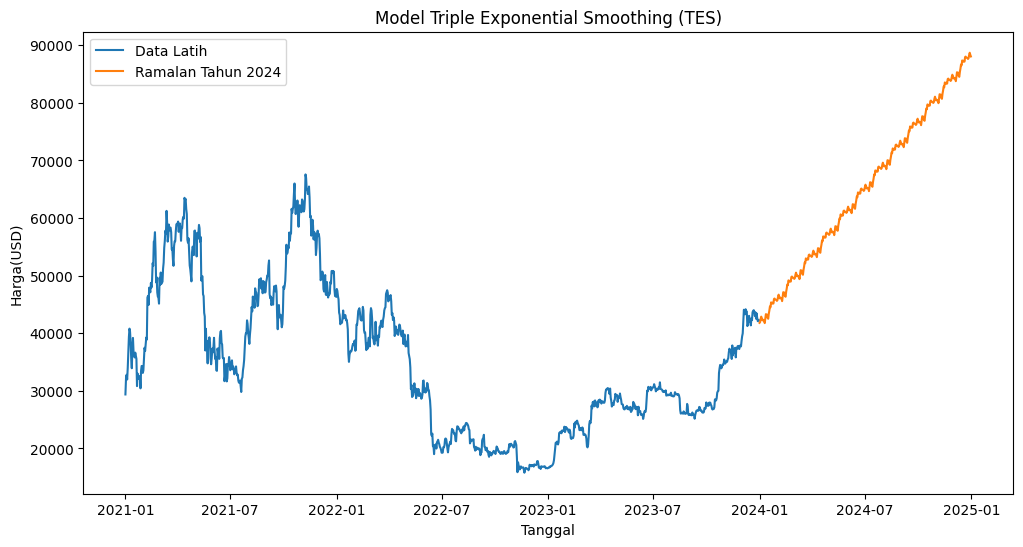

In [86]:
# Mengasumsikan saya memiliki data latihan (train_final) dan data uji (test_final) yang sudah dipersiapkan
# Data latihan: 2021-01-01 hingga 2023-05-26
# Data uji: 2023-05-27 hingga 2023-12-31

# Menggabungkan data latihan dan data uji
combined_data = pd.concat([train_final['Close_interpolated'], test_final['Close_interpolated']])

# Melatih model Triple Exponential Smoothing (TES)
seasonal_periods = 30  # Set the seasonal period to 30 days
model = ExponentialSmoothing(combined_data, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
 # Best parameters
model_fit = model.fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

# Membuat DataFrame untuk data ramalan tahun 2024
forecast_2024_TES = pd.DataFrame(index=pd.date_range(start='2024-01-01', end='2024-12-31', freq='D'), columns=['Close_interpolated'])

# Meramalkan harga untuk tahun 2024
forecast_2024_TES['Close_interpolated'] = model_fit.forecast(steps=len(forecast_2024_TES))

# plot
plt.figure(figsize=(12, 6))
plt.plot(combined_data, label='Data Latih')
plt.plot(forecast_2024_TES, label='Ramalan Tahun 2024')
plt.legend()
plt.title('Model Triple Exponential Smoothing (TES)')
plt.xlabel('Tanggal')
plt.ylabel('Harga(USD)')
plt.show()


In [87]:
# Ekspor ke file CSV dengan nama dan lokasi tertentu
forecast_2024_TES.to_csv('ramalan_2024_TES.csv', index=True, index_label='Tanggal')

## ARIMA

In [88]:
#Hyperparameter Tuning ARIMA
def arima_optimizer(train, test, pdq):
    best_p, best_d, best_q, best_mae = None, None, None, float("inf")
    start_time = time.time()
    
    for comb in pdq:
        try:
            arima_model = ARIMA(train, order=comb).fit()
            y_pred = arima_model.forecast(len(test))
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_p, best_d, best_q, best_mae = comb[0], comb[1], comb[2], mae
        except:
            continue
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print("Hyperparameter tuning completed in {:.2f} seconds".format(elapsed_time))
    print("Best Parameters -> p: {}, d: {}, q: {}, MAE: {:.4f}".format(best_p, best_d, best_q, best_mae))

    return best_p, best_d, best_q, best_mae

# Generate combinations of p, d, q
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Train the model and optimize hyperparameters
best_p, best_d, best_q, _ = arima_optimizer(arima_train_df['Close_interpolated'], arima_test_df['Close_interpolated'], pdq)

#Fit Model ARIMA
def fit_arima(train, test, order):
    # Build the model
    model = ARIMA(train, order=order)
    
    # Fit the model
    model_fit = model.fit()
    
    # Forecast
    Tuning_ARIMA = model_fit.forecast(steps=len(test))
    
    return model_fit, Tuning_ARIMA

# Fit the model with best hyperparameters
order = (best_p, best_d, best_q)
model_fit, Tuning_ARIMA = fit_arima(arima_train_df['Close_interpolated'], arima_test_df['Close_interpolated'], order)

Hyperparameter tuning completed in 9.37 seconds
Best Parameters -> p: 2, d: 2, q: 0, MAE: 3711.8482


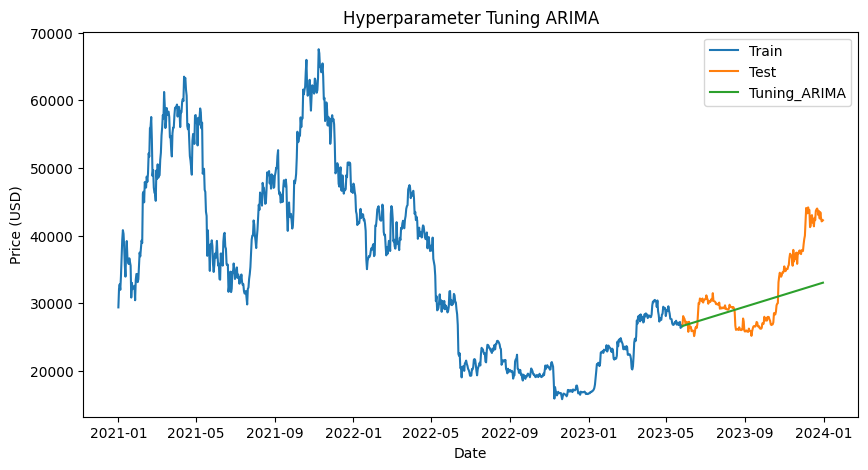

Best p: 2
Best d: 2
Best q: 0
RMSE Tuned ARIMA: 4731.45
MAPE Tuned ARIMA: 10.95%


In [97]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(arima_train_df['Close_interpolated'], label='Train')
plt.plot(arima_test_df['Close_interpolated'], label='Test')
plt.plot(Tuning_ARIMA, label='Tuning_ARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.title('Hyperparameter Tuning ARIMA')
plt.show()
# Evaluate the model RMSE n MAPE
rmse_tuned_ARIMA = np.sqrt(mean_squared_error(arima_test_df['Close_interpolated'], Tuning_ARIMA))
mape_tuned_ARIMA = np.mean(np.abs((arima_test_df['Close_interpolated'] - Tuning_ARIMA) / arima_test_df['Close_interpolated'])) * 100
#print for ARIMa
print(f'Best p: {best_p}')
print(f'Best d: {best_d}')
print(f'Best q: {best_q}')
print(f'RMSE Tuned ARIMA: {rmse_tuned_ARIMA:.2f}')
print(f'MAPE Tuned ARIMA: {mape_tuned_ARIMA:.2f}%')

## ARIMA 2024

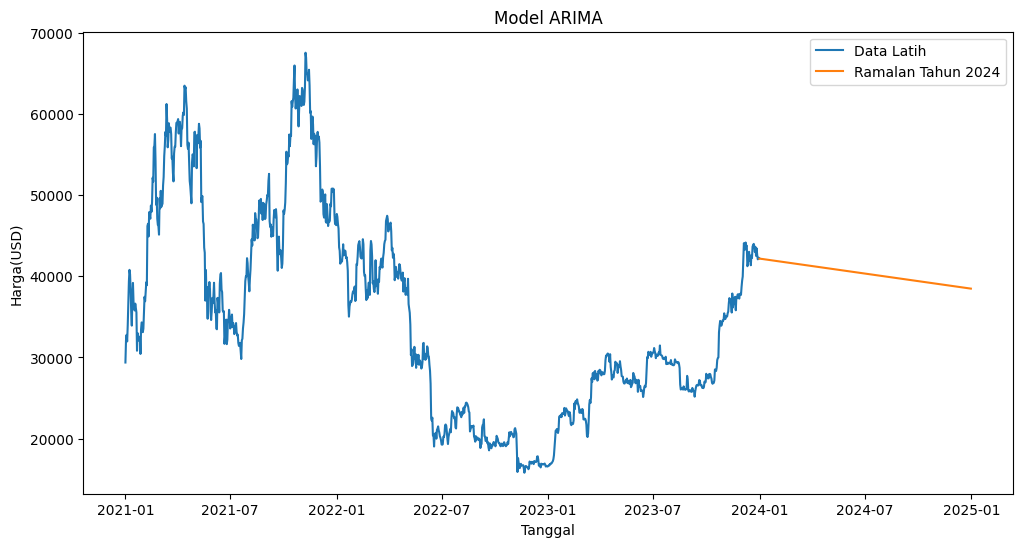

In [90]:
# Fit ARIMA model
model = ARIMA(combined_data, order=(best_p, best_d, best_q))
model_fit = model.fit()

# Membuat DataFrame untuk data ramalan tahun 2024
forecast_2024_ARIMA = pd.DataFrame(index=pd.date_range(start='2024-01-01', end='2024-12-31', freq='D'), columns=['Close_interpolated'])

# Meramalkan harga untuk tahun 2024
forecast_2024_ARIMA['Close_interpolated'] = model_fit.forecast(steps=len(forecast_2024_ARIMA))

# plot
plt.figure(figsize=(12, 6))
plt.plot(combined_data, label='Data Latih')
plt.plot(forecast_2024_ARIMA, label='Ramalan Tahun 2024')
plt.legend()
plt.title('Model ARIMA')
plt.xlabel('Tanggal')
plt.ylabel('Harga(USD)')
plt.show()

In [91]:
# Ekspor ke file CSV dengan nama dan lokasi tertentu
forecast_2024_ARIMA.to_csv('ramalan_2024_ARIMA.csv', index=True, index_label='Tanggal')

# Evaluation

## Export Data

In [92]:
# Create a DataFrame with Actual and Predicted values for TES model
df_prediksi_TES = pd.DataFrame({'Actual': hw_test_df['Close_interpolated'], 'Predicted': Tuning_TES})

# Calculate Absolute Difference
df_prediksi_TES['Perbedaan Absolut'] = abs(df_prediksi_TES['Actual'] - df_prediksi_TES['Predicted'])

# Calculate Relative Difference in percentage
df_prediksi_TES['Perbedaan Relatif (%)'] = (abs(df_prediksi_TES['Actual'] - df_prediksi_TES['Predicted']) / df_prediksi_TES['Actual']) * 100

# Save to CSV
df_prediksi_TES.to_csv('tes_predictions_Close.csv', index=True)

df_prediksi_TES

,Actual,Predicted,Perbedaan Absolut,Perbedaan Relatif (%)
2023-05-27,26868.353516,26763.391948,104.961568,0.390651
2023-05-28,28085.646484,27166.482881,919.163603,3.272717
2023-05-29,27745.884766,27413.452656,332.432110,1.198131
2023-05-30,27702.349609,27614.019036,88.330573,0.318856
2023-05-31,27219.658203,27215.063898,4.594305,0.016879
...,...,...,...,...
2023-12-27,43442.855469,40481.125451,2961.730018,6.817531
2023-12-28,42627.855469,40462.780510,2165.074959,5.079014
2023-12-29,42099.402344,40434.891537,1664.510807,3.953764
2023-12-30,42156.902344,40556.505730,1600.396614,3.796286


In [93]:
# Create a DataFrame with Actual and Predicted values for ARIMA model

df_prediksi_ARIMA = pd.DataFrame({'Actual': arima_test_df['Close_interpolated'], 'Predicted': Tuning_ARIMA},)

# Calculate Absolute Difference
df_prediksi_ARIMA['Perbedaan Absolut'] = abs(df_prediksi_ARIMA['Actual'] - df_prediksi_ARIMA['Predicted'])

# Calculate Relative Difference in percentage
df_prediksi_ARIMA['Perbedaan Relatif (%)'] = (abs(df_prediksi_ARIMA['Actual'] - df_prediksi_ARIMA['Predicted']) / df_prediksi_ARIMA['Actual']) * 100

# Save to CSV
df_prediksi_ARIMA.to_csv('arima_predictions_Close.csv', index=True)

df_prediksi_ARIMA

,Actual,Predicted,Perbedaan Absolut,Perbedaan Relatif (%)
2023-05-27,26868.353516,26579.796663,288.556853,1.073966
2023-05-28,28085.646484,26649.241718,1436.404766,5.114373
2023-05-29,27745.884766,26705.542022,1040.342744,3.749539
2023-05-30,27702.349609,26705.595491,996.754118,3.598085
2023-05-31,27219.658203,26745.041209,474.616994,1.743655
...,...,...,...,...
2023-12-27,43442.855469,32909.616951,10533.238518,24.246193
2023-12-28,42627.855469,32938.973073,9688.882396,22.728993
2023-12-29,42099.402344,32968.329196,9131.073148,21.689318
2023-12-30,42156.902344,32997.685318,9159.217026,21.726494


## Data Frame with Actual & Predicted

In [94]:
# Create a DataFrame with Actual and Predicted values for TES & ARIMA Model (Compare)
df_prediksi_compare = pd.DataFrame({'Harga Aktual': hw_test_df['Close_interpolated'], 'Prediksi TES': Tuning_TES, 'Prediksi ARIMA': Tuning_ARIMA, 'Selisih TES':df_prediksi_TES['Perbedaan Absolut'], 'Selisih ARIMA':df_prediksi_ARIMA['Perbedaan Absolut']})

# Save to CSV
df_prediksi_compare.to_csv('Compare_predictions_Close.csv', index=True)

df_prediksi_compare

,Harga Aktual,Prediksi TES,Prediksi ARIMA,Selisih TES,Selisih ARIMA
2023-05-27,26868.353516,26763.391948,26579.796663,104.961568,288.556853
2023-05-28,28085.646484,27166.482881,26649.241718,919.163603,1436.404766
2023-05-29,27745.884766,27413.452656,26705.542022,332.432110,1040.342744
2023-05-30,27702.349609,27614.019036,26705.595491,88.330573,996.754118
2023-05-31,27219.658203,27215.063898,26745.041209,4.594305,474.616994
...,...,...,...,...,...
2023-12-27,43442.855469,40481.125451,32909.616951,2961.730018,10533.238518
2023-12-28,42627.855469,40462.780510,32938.973073,2165.074959,9688.882396
2023-12-29,42099.402344,40434.891537,32968.329196,1664.510807,9131.073148
2023-12-30,42156.902344,40556.505730,32997.685318,1600.396614,9159.217026


## Kesimpulan

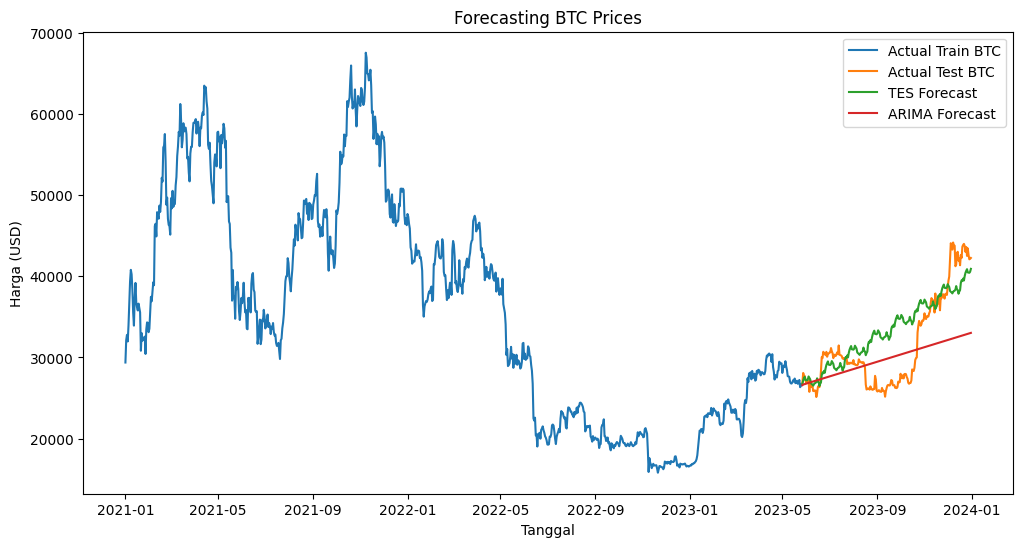

In [95]:
# Plotting the forecasts
plt.figure(figsize=(12, 6))
plt.plot(arima_train_df['Close_interpolated'], label='Actual Train BTC')
plt.plot(arima_test_df['Close_interpolated'], label='Actual Test BTC')
plt.plot(Tuning_TES, label='TES Forecast')
plt.plot(Tuning_ARIMA, label='ARIMA Forecast')
plt.legend()
plt.title('Forecasting BTC Prices')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.show()

In [96]:
comparison_df = pd.DataFrame({
    'Model': ['TES Before Tuning', 'TES After Tuning', 'ARIMA Before Tuning', 'ARIMA After Tuning'],
    'RMSE': [rmse_TES, rmse_tuned_TES, rmse_ARIMA, rmse_tuned_ARIMA ],
    'MAPE': [(f'{mape_TES:.2f}%'), (f'{mape_tuned_TES:.2f}%'), (f'{mape_ARIMA:.2f}%'), (f'{mape_tuned_ARIMA:.2f}%')],
})

# Display the comparison DataFrame
print(tabulate(comparison_df, headers='keys', tablefmt='pipe', showindex=False))

| Model               |    RMSE | MAPE   |
|:--------------------|--------:|:-------|
| TES Before Tuning   | 8540.2  | 16.29% |
| TES After Tuning    | 4130.77 | 10.93% |
| ARIMA Before Tuning | 7390.74 | 13.74% |
| ARIMA After Tuning  | 4731.45 | 10.95% |


Kesimpulan

Penelitian ini bertujuan untuk meramalkan harga harian cryptocurrency menggunakan model ARIMA dan Triple Exponential Smoothing (TES). Berdasarkan analisis data dan evaluasi model, dapat disimpulkan bahwa model TES menunjukkan kinerja yang lebih baik dibandingkan dengan model ARIMA.

Hasil evaluasi menunjukkan bahwa TES memiliki RMSE sebesar 4130.77 dan MAPE sebesar 10.93%, sementara ARIMA memiliki RMSE sebesar 4731.45 dan MAPE sebesar 10.95%. Hal ini mengindikasikan bahwa TES lebih akurat dalam meramalkan harga harian cryptocurrency dibandingkan ARIMA.

Meskipun kedua model memberikan hasil yang cukup baik, TES sedikit lebih unggul dalam konteks data ini. Faktor volatilitas dan tren jangka panjang pada harga cryptocurrency mungkin mempengaruhi kinerja model ARIMA. Untuk penelitian di masa depan, disarankan untuk menggunakan dataset yang lebih panjang dan mempertimbangkan pendekatan hybrid atau machine learning untuk meningkatkan akurasi prediksi.

Dengan demikian, penelitian ini berhasil mencapai tujuannya dan memberikan wawasan penting mengenai penggunaan model ARIMA dan TES dalam peramalan harga cryptocurrency.
